In [56]:
import importlib
import modules
from collections import Counter
import numpy as np

importlib.reload(modules)

from modules import CA
import matplotlib.pyplot as plt
import cellpylib as cpl
from modules import triangulize_evolution
from modules import find_elem_jams
import scipy
import scipy.optimize as opt

from modules import initial_to_random_walk
from modules import run_model
from modules import jam_lifespans

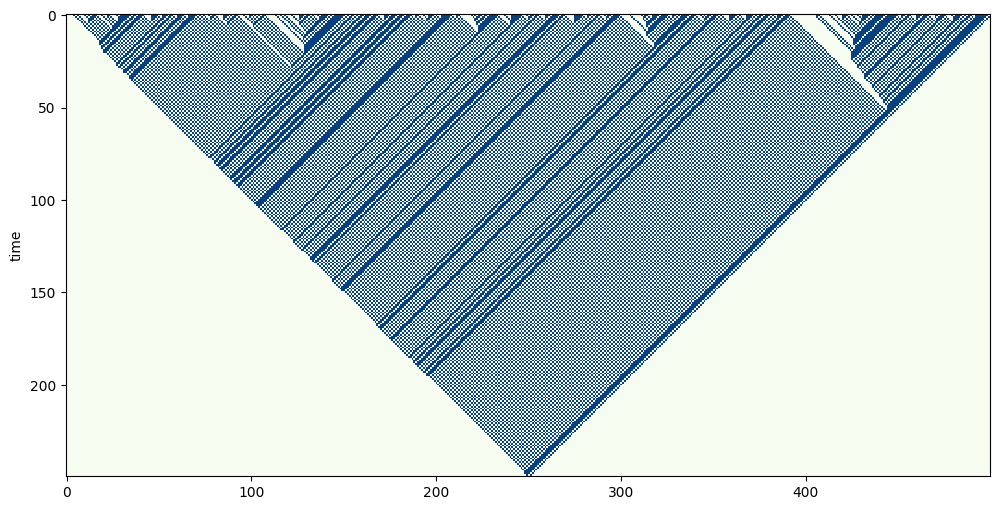

In [100]:
p = 0.5
L = 500
T = int(L / 2)
n_repetitions = 100
n_alpha = 2
p_values = [0.2,0.3,0.4,0.5,0.6,0.7] # Adjust as needed (np.linspace(0.1, 0.7, 7), to get same results as paper)
initial_state = ca_184.gen_initial_state_bernoulli(L, p)

# print(cellular_automaton)
cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
cellular_automaton = triangulize_evolution(cellular_automaton)

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(cellular_automaton, colormap='GnBu')

# Plot the random walk that is the initial state, go up for 1, down for 0
random_walk = initial_to_random_walk(initial_state)


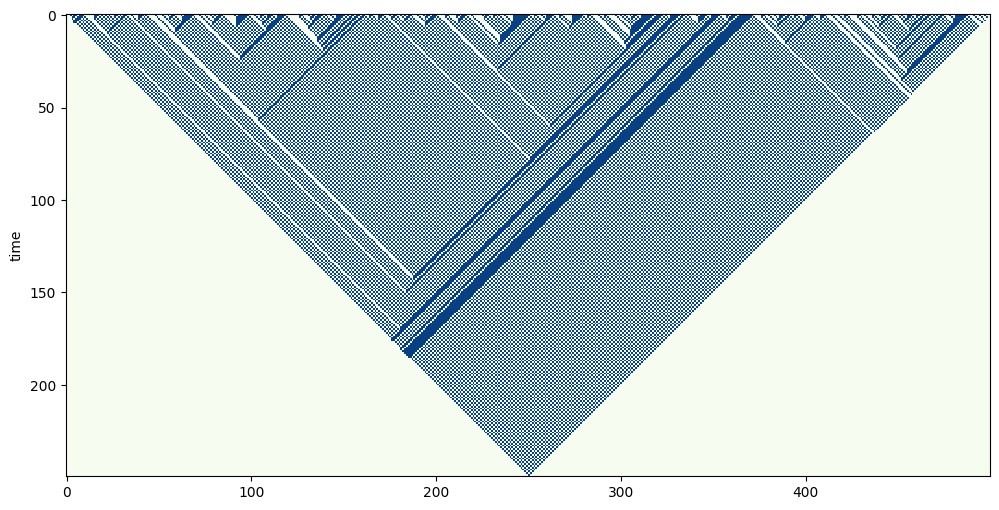

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


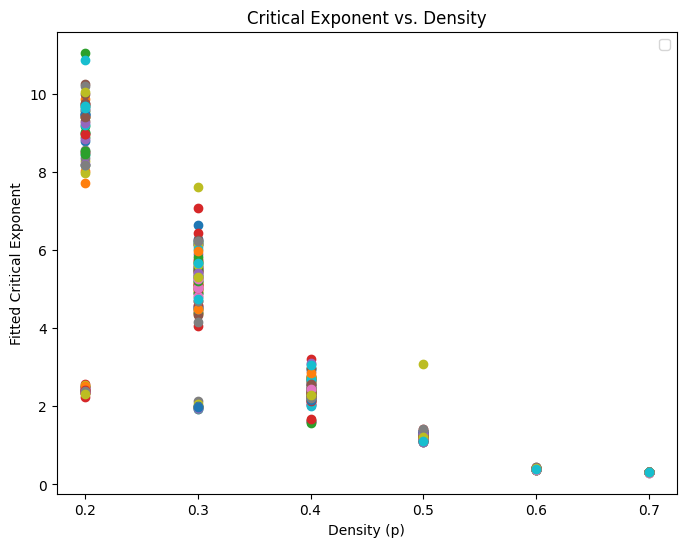

In [94]:

def run_model_over_density(p_values, L, T, n_repetitions=100):
    """
    Function to run the model for different density values.

    Parameters:
    - p_values (list): List of float values representing different densities.
    - L (int): The length of the CA.
    - T (int): The number of timesteps.
    - n_repetitions (int): The number of times the model should be run for each density.

    Returns:
    - lifespan_counters (list): List of Counters with lifespans for each density.
    - jam_counters (list): List of Counters with jam sizes for each density.
    - Results: list with density and related jam_counters
    """
    lifespan_counters = []
    jam_counters_list = []  #Changed to a list

    for p in p_values: #loop over different densities (p)
        total_lifespans = []
        total_jam_sizes = []

        for i in range(n_repetitions):
            ca_184 = CA()
            initial_state = ca_184.gen_initial_state_bernoulli(L, p)
            random_walk = initial_to_random_walk(initial_state)
            cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
            cellular_automaton = triangulize_evolution(cellular_automaton)

            lifespans = jam_lifespans(random_walk)
            total_lifespans += lifespans
            
            jams = find_elem_jams(cellular_automaton)
            jam_sizes = [jam[1] for jam in jams]
            total_jam_sizes += jam_sizes
        
        lifespan_counters.append(Counter(total_lifespans))
        jam_counters_list.append(Counter(total_jam_sizes))

    #Connect jam counts with density values for fit_power_law function
    results = [(p, jam_counters) for p, jam_counters in zip(p_values, jam_counters_list)]

    return lifespan_counters, results



def fit_power_law(results):
    """ Function to fit a power-law function to fit the different densities (p) and """
    fitted_parameters = []

    for p, jam_counters in results:
        lists = sorted(jam_counters.items())
        x, y = zip(*lists)

        # Fit power-law function
        def func(x, a, b):
            return a * x ** -b

        popt, pcov = scipy.optimize.curve_fit(func, x, y, p0=[1, 0.1])
        a_optimal, b_optimal = popt

        fitted_parameters.append((p, b_optimal))

    return fitted_parameters

# Example usage
n_alpha = 100  # Define the number of iterations
all_densities = []
all_critical_exponents = []

for _ in range(n_alpha):
    # Assuming you have already run_model_over_density and obtained results
    lifespan_counters, results_x = run_model_over_density(p_values, L, T, n_repetitions)

    # Fit power-law and get fitted parameters
    fitted_parameters = fit_power_law(results_x)

    # Extract density and critical exponent values
    densities, critical_exponents = zip(*fitted_parameters)

    # Accumulate the results
    all_densities.append(densities)
    all_critical_exponents.append(critical_exponents)

# Plot the results
plt.figure(figsize=(8, 6))
for i in range(n_alpha):
    plt.plot(all_densities[i], all_critical_exponents[i], 'o')

plt.xlabel('Density (p)')
plt.ylabel('Fitted Critical Exponent')
plt.title('Critical Exponent vs. Density')
plt.legend()
plt.show()



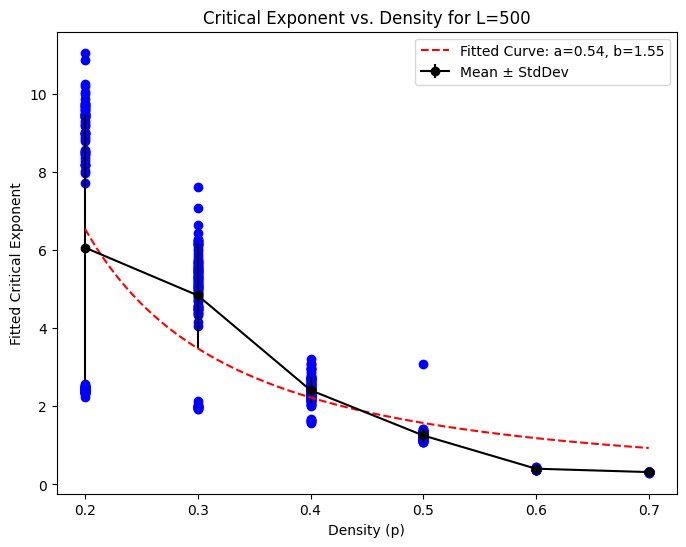

In [99]:

#fit power law curve: density as a function of the critical exponents
# Calculate mean and standard deviation of critical exponents
mean_critical_exponents = np.mean(all_critical_exponents, axis=0)
std_critical_exponents = np.std(all_critical_exponents, axis=0)

# Fit a curve to the mean critical exponents
def func(x, a, b):
    return a * x ** -b 

popt, pcov = curve_fit(func, all_densities[0], mean_critical_exponents, p0=[1, 0.5])

# Plot the results
plt.figure(figsize=(8, 6))

#Plot individual datapoints from iterations
for i in range(n_alpha):
    plt.plot(all_densities[i], all_critical_exponents[i], 'o', color="blue")

#Plot the mean values with std dev
plt.errorbar(all_densities[0], mean_critical_exponents, yerr=std_critical_exponents, fmt='o-', color='black', label='Mean ± StdDev')

#plot the fitted curve
x_fit = np.linspace(min(all_densities[0]), max(all_densities[0]), 100)
y_fit = func(x_fit, *popt)
plt.plot(x_fit, y_fit, '--', color='red', label=f'Fitted Curve: a={popt[0]:.2f}, b={popt[1]:.2f}')

plt.xlabel('Density (p)')
plt.ylabel('Fitted Critical Exponent')
plt.title('Critical Exponent vs. Density for L=500')
plt.legend()
plt.show()


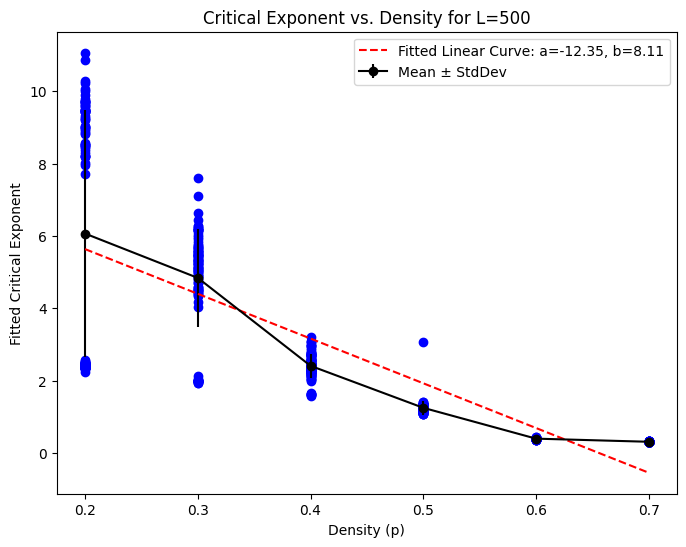

In [96]:

#fit linear curve: density as a function of the critical exponents
# Calculate mean and standard deviation of critical exponents
mean_critical_exponents = np.mean(all_critical_exponents, axis=0)
std_critical_exponents = np.std(all_critical_exponents, axis=0)

# Fit a linear curve to the mean critical exponents
def linear_func(x, a, b):
    return a * x + b

popt_linear, pcov_linear = curve_fit(linear_func, all_densities[0], mean_critical_exponents, p0=[1, 0.5])

# Plot the results
plt.figure(figsize=(8, 6))

# Plot individual datapoints from iterations
for i in range(n_alpha):
    plt.plot(all_densities[i], all_critical_exponents[i], 'o', color="blue")

# Plot the mean values with std dev
plt.errorbar(all_densities[0], mean_critical_exponents, yerr=std_critical_exponents, fmt='o-', color='black', label='Mean ± StdDev')

# Plot the fitted linear curve
x_fit = np.linspace(min(all_densities[0]), max(all_densities[0]), 100)
y_fit_linear = linear_func(x_fit, *popt_linear)
plt.plot(x_fit, y_fit_linear, '--', color='red', label=f'Fitted Linear Curve: a={popt_linear[0]:.2f}, b={popt_linear[1]:.2f}')

plt.xlabel('Density (p)')
plt.ylabel('Fitted Critical Exponent')
plt.title('Critical Exponent vs. Density for L=500')
plt.legend()
plt.show()
